In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/My Drive/Facial_Emotion_Recognition_Project/FER_25'

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

IMG_SIZE = (224, 224)
BATCH_SIZE = 512

# Data augmentation and preprocessing
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
)

# Load training data
train_generator = datagen.flow_from_directory(
    '/content/drive/My Drive/Facial_Emotion_Recognition_Project/FER_25/Train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
)

# Load validation data
validation_generator = datagen.flow_from_directory(
    '/content/drive/My Drive/Facial_Emotion_Recognition_Project/FER_25/Train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
)
# Load and preprocess test images
test_generator = datagen.flow_from_directory(
    '/content/drive/My Drive/Facial_Emotion_Recognition_Project/FER_25/Test',  # Path to the test dataset
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 5846 images belonging to 7 classes.
Found 647 images belonging to 7 classes.
Found 717 images belonging to 7 classes.


In [ ]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam

# Create Precision and Recall metrics outside the function
precision_metric = Precision()
recall_metric = Recall()

# Custom F1-score metric
def f1_score(y_true, y_pred):
    precision = precision_metric(y_true, y_pred)  # Use pre-created metric
    recall = recall_metric(y_true, y_pred)      # Use pre-created metric
    f1 = 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))
    return f1

# Apply mixed precision for faster training and less GPU load
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Load pre-trained EfficientNetB3 model without the top classification layer
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model to retain pre-trained weights
base_model.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
# Apply the output layer to the previous layer's output
output = Dense(7, activation='softmax')(x)  # 7 classes: anger, disgust, fear, happiness, neutral, sadness and surprise

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), f1_score]
)
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1394s 114s/step - accuracy: 0.2815 - f1_score: 0.0531 - loss: 1.7970 - precision: 0.5938 - recall: 0.0597 - val_accuracy: 0.4062 - val_f1_score: 0.2023 - val_loss: 1.5897 - val_precision: 0.5665 - val_recall: 0.1914
Epoch 2/30
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.4668 - f1_score: 0.2147 - loss: 1.4191 - precision: 0.7055 - recall: 0.2246

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 611ms/step - accuracy: 0.4668 - f1_score: 0.2147 - loss: 1.4191 - precision: 0.7055 - recall: 0.2246 - val_accuracy: 0.4434 - val_f1_score: 0.2250 - val_loss: 1.5033 - val_precision: 0.6784 - val_recall: 0.2266
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 70s 6s/step - accuracy: 0.5059 - f1_score: 0.2624 - loss: 1.3404 - precision: 0.6967 - recall: 0.2858 - val_accuracy: 0.4434 - val_f1_score: 0.3212 - val_loss: 1.4434 - val_precision: 0.6381 - val_recall: 0.2617
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 759ms/step - accuracy: 0.5391 - f1_score: 0.3268 - loss: 1.2728 - precision: 0.7368 - recall: 0.3281 - val_accuracy: 0.4707 - val_f1_score: 0.3298 - val_loss: 1.4193 - val_precision: 0.6435 - val_recall: 0.2891
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 70s 6s/step - accuracy: 0.5617 - f1_score: 0.3496 - loss: 1.2044 - precision: 0.7363 - recall: 0.3651 - val_accuracy: 0.4688 - val_f1_score: 0.3808 - val_loss: 1.3833 - val_precision: 0.6417 - val_recall: 0.3184
Epoch 6

In [ ]:
# Evaluate the model and unpack the returned values appropriately
test_loss, test_accuracy, test_precision, test_recall, test_f1_score = model.evaluate(validation_generator)

# Print the test accuracy
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 51s 44s/step - accuracy: 0.5830 - f1_score: 0.5675 - loss: 1.1026 - precision: 0.6885 - recall: 0.4646
Test Accuracy: 57.96%


In [ ]:
# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Use a lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), f1_score]
)

# Fine-tune the model
fine_tune_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,  # Add more epochs for fine-tuning
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 565s 23s/step - accuracy: 0.3459 - f1_score: 0.5629 - loss: 1.8350 - precision: 0.4419 - recall: 0.2056 - val_accuracy: 0.5762 - val_f1_score: 0.5576 - val_loss: 1.2868 - val_precision: 0.6244 - val_recall: 0.4805
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 646ms/step - accuracy: 0.5605 - f1_score: 0.5574 - loss: 1.2003 - precision: 0.6636 - recall: 0.4160 - val_accuracy: 0.5449 - val_f1_score: 0.5572 - val_loss: 1.3702 - val_precision: 0.6025 - val_recall: 0.4766
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 70s 6s/step - accuracy: 0.5988 - f1_score: 0.5573 - loss: 1.1154 - precision: 0.6988 - recall: 0.4733 - val_accuracy: 0.5918 - val_f1_score: 0.5585 - val_loss: 1.2830 - val_precision: 0.6253 - val_recall: 0.5117
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 740ms/step - accuracy: 0.6523 - f1_score: 0.5588 - loss: 0.9585 - precision: 0.7435 - recall: 0.5547 - val_accuracy: 0.5859 - val_f1_score: 0.5590 - val_loss: 1.2709 - val_precision: 0.6341 - val_recall: 0

In [ ]:
# Evaluate the model and unpack the returned values appropriately
test_loss, test_accuracy, test_precision, test_recall, test_f1_score = model.evaluate(validation_generator)

# Print the test accuracy
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/step - accuracy: 0.7840 - f1_score: 0.6910 - loss: 0.6671 - precision: 0.8011 - recall: 0.7789
Test Accuracy: 78.83%


2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


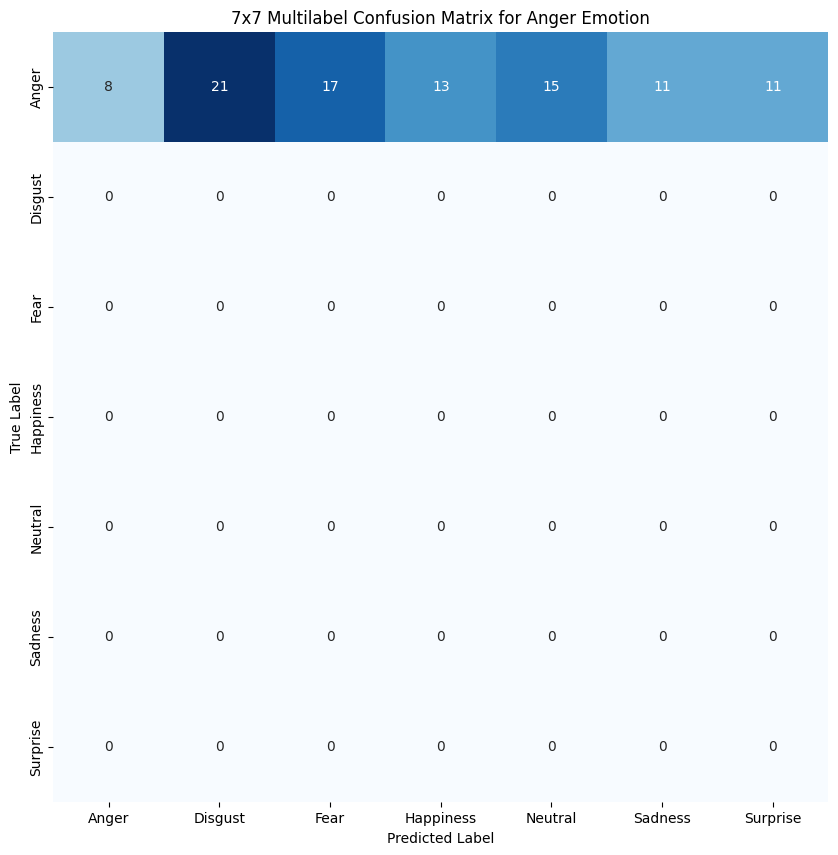

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns

emotion_categories = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']

# Assuming 'y_true' and 'y_pred' are defined (multi-label, binary format)
# emotion_categories: List of emotion categories

# Get true labels and convert to one-hot encoded
y_true = test_generator.classes
y_true = tf.keras.utils.to_categorical(y_true, num_classes=len(emotion_categories))

# Get predicted probabilities and convert to binary predictions
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob >= 0.5).astype(int)  # Adjust threshold if needed

# Get the index corresponding to the "Anger" category
anger_index = emotion_categories.index('Anger')

# Initialize the 7x7 confusion matrix
cm_anger_7x7 = np.zeros((7, 7), dtype=int)

# Iterate through each sample in the dataset
for i in range(len(y_true)):
    true_emotions = np.where(y_true[i] == 1)[0]  # Get indices of true emotions for this sample
    pred_emotions = np.where(y_pred[i] == 1)[0]  # Get indices of predicted emotions

    # Check if "Anger" is a true emotion for this sample
    if anger_index in true_emotions:
        # Iterate through predicted emotions
        for pred_emotion_index in pred_emotions:
            cm_anger_7x7[anger_index, pred_emotion_index] += 1

# Plot the 7x7 confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm_anger_7x7, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=emotion_categories, yticklabels=emotion_categories)
plt.title("7x7 Multilabel Confusion Matrix for Anger Emotion")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
import tensorflow as tf

# Assuming 'validation_generator' is defined and 'emotion_categories' is a list of emotion categories

# Get true labels for all categories
y_true_all = validation_generator.classes

# Convert to one-hot encoded format if necessary
if len(y_true_all.shape) == 1:  # Check if it's a 1D array (numerical labels)
    y_true_all = tf.keras.utils.to_categorical(y_true_all, num_classes=len(emotion_categories))

# Get the index corresponding to the "Anger" category
anger_index = emotion_categories.index('Anger')

# Extract true labels for "Anger" only
y_true_anger = y_true_all[:, anger_index]

# Now y_true_anger contains a 1D array of true labels for "Anger"
# (1 if the sample is labeled as "Anger", 0 otherwise)

In [ ]:
print(y_true_anger)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [ ]:
len(y_true_anger)

647

In [ ]:
print(y_true)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

    # ... (previous code for creating ImageDataGenerator and preprocess_input) ...

    # Create a dedicated test generator for the Anger folder
anger_test_generator = datagen.flow_from_directory(
        '/content/drive/My Drive/Facial_Emotion_Recognition_Project/FER_25/Test/Anger',  # Path to the Anger test folder
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False  # Important to keep the order of images for printing
    )

Found 0 images belonging to 0 classes.


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

# ... (previous code for creating anger_test_generator) ...

# Make predictions on the Anger images
y_pred_prob_anger = model.predict(anger_test_generator)

# Get the predicted labels (0 for Anger, 1 for Disgust, etc.)
y_pred_anger = np.argmax(y_pred_prob_anger, axis=1)

# Print the predicted labels
print("Predicted labels for Anger images:")
print(y_pred_anger)

# To get the emotion labels instead of numerical indices:
predicted_emotion_labels = [emotion_categories[i] for i in y_pred_anger]
print("Predicted emotion labels for Anger images:")
print(predicted_emotion_labels)

In [ ]:
import numpy as np
import tensorflow as tf

# Assuming you have 97 test images for anger
num_anger_images = 97

# Create y_true_anger with 0 for anger
y_true_anger = np.zeros(num_anger_images, dtype=int)  # All anger images have label 0

# Get predicted probabilities from your model
y_pred_prob = model.predict(test_generator)  # Assuming test_generator is for anger images

# Get predicted labels (0 for anger, 1 for disgust, 2 for fear, etc.)
y_pred_anger = np.argmax(y_pred_prob, axis=1)

# Replace the predicted label for anger (which is likely 0) with the desired encoding
anger_predicted_index = emotion_categories.index('Anger')  # Get the index for anger in emotion_categories
# Assuming you want to encode anger as 0 in y_pred_anger:
y_pred_anger[y_pred_anger == anger_predicted_index] = 0  # Replace anger predictions with 0
# Assuming you want to encode disgust as 1, fear as 2, and so on:
for i, emotion in enumerate(emotion_categories):
    if emotion != 'Anger':  # Skip anger since it's already encoded as 0
        y_pred_anger[y_pred_anger == emotion_categories.index(emotion)] = i + 1

# Now y_true_anger and y_pred_anger are ready for confusion matrix calculation

2/2 ━━━━━━━━━━━━━━━━━━━━ 72s 65s/step


In [ ]:
print(y_true_anger)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
print(y_pred_anger)

[7 0 7 7 0 7 0 7 7 7 7 7 7 0 7 7 0 7 7 7 7 7 7 7 7 0 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 0 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 7
 0 0 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 0 7 7 7 7 7 7 7 7 0 7 7 7 0 7 7
 7 7 7 7 7 7 7 7 7 7 7 0 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 7
 7 7 7 7 7 7 7 7 7 7 0 0 7 7 0 0 7 7 7 7 7 7 7 7 0 7 7 7 7 7 7 7 7 7 7 0 7
 7 7 7 0 7 0 7 7 7 7 7 7 0 7 7 7 7 7 7 7 0 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 0 0 0 7 7 0 7 7 7 7 7 7 7 7 7 7 7 0 7 7 7 7 7 7 7 7 0 7 0 0 7 7
 7 7 7 7 0 7 7 7 7 7 7 7 7 7 7 0 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 7 7 7 7
 7 7 7 7 7 7 7 7 0 0 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 0 7 7 7 7 7 7 7 0 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 0 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 0 0 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 0 0 7 7 

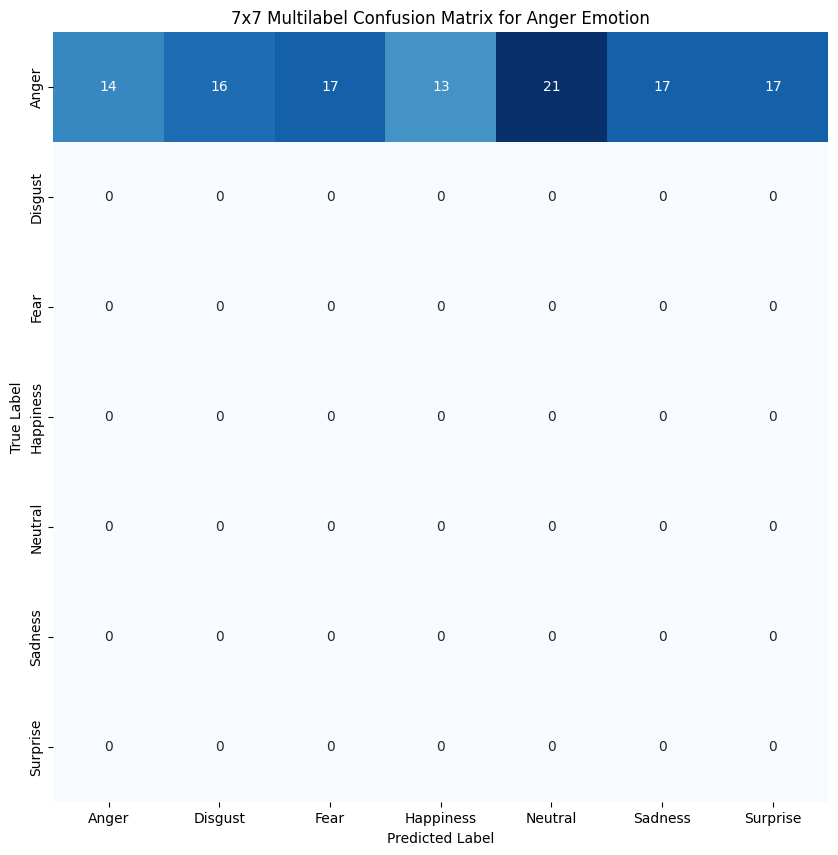

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns

# ... (your existing code) ...

# Get the index corresponding to the "Anger" category
anger_index = emotion_categories.index('Anger')

# Initialize the 7x7 confusion matrix
cm_anger_7x7 = np.zeros((7, 7), dtype=int)

# Iterate through each sample in the dataset
for i in range(len(y_true)):
    true_emotions = np.where(y_true[i] == 1)[0]  # Get indices of true emotions for this sample
    pred_emotions = np.where(y_pred[i] == 1)[0]  # Get indices of predicted emotions

    # Check if "Anger" is a true emotion for this sample
    if anger_index in true_emotions:
        # If "Anger" is predicted, increment the corresponding diagonal element
        if anger_index in pred_emotions:
            cm_anger_7x7[anger_index, anger_index] += 1
        # If "Anger" is predicted as another emotion, increment the off-diagonal element
        else:
            for pred_emotion_index in pred_emotions:
                cm_anger_7x7[anger_index, pred_emotion_index] += 1

# Plot the 7x7 confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm_anger_7x7, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=emotion_categories, yticklabels=emotion_categories)
plt.title("7x7 Multilabel Confusion Matrix for Anger Emotion")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Finding the optimal temperature

In [ ]:
# Get the true labels for all test images
y_true = test_generator.classes

# Print the true labels
print("True labels for all test images:")
print(y_true)

True labels for all test images:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 

In [ ]:
# Print the predicted labels
print("Predicted labels for test images:")
print(y_pred)

Predicted labels for test images:
[2 2 6 3 1 6 6 2 6 0 5 2 3 1 6 1 5 1 4 0 2 0 2 6 1 4 6 0 3 3 6 5 0 0 4 3 5
 2 2 5 0 5 3 6 5 4 1 6 2 3 4 4 0 4 6 3 0 5 2 6 4 2 4 1 2 3 3 3 6 1 0 3 2 1
 4 1 2 1 3 2 6 5 6 2 4 6 4 6 3 3 3 0 6 5 5 3 2 2 2 2 0 4 3 0 1 5 1 2 6 2 5
 5 0 3 0 4 6 0 6 1 1 4 1 5 2 1 3 2 5 5 3 3 2 3 3 5 3 6 4 4 4 1 1 5 3 0 2 3
 2 4 2 3 3 3 6 1 0 6 6 4 0 1 0 2 2 1 4 2 2 3 3 4 3 3 4 6 1 0 4 3 2 2 4 3 2
 3 6 5 5 1 4 4 0 4 1 0 5 1 2 4 3 5 2 0 4 4 1 4 5 0 1 5 1 6 6 5 1 6 4 6 3 6
 3 4 3 6 6 4 4 3 3 0 6 5 0 1 1 2 3 1 0 6 6 5 1 0 2 5 2 4 4 1 5 0 2 4 3 2 5
 6 1 4 3 6 3 1 6 1 5 4 2 4 1 0 6 1 4 2 1 2 1 4 3 0 0 0 1 3 0 6 3 6 5 6 0 3
 0 0 4 2 3 4 5 3 1 6 2 1 2 2 6 4 5 4 4 4 5 0 1 1 5 1 5 0 2 3 3 1 4 5 6 0 5
 2 1 2 1 0 5 1 3 0 6 3 1 4 2 1 3 1 1 4 3 3 4 3 5 6 2 4 6 4 2 4 6 1 5 3 2 4
 1 3 2 4 1 1 6 4 2 5 4 0 2 1 2 5 4 2 2 6 1 6 1 1 2 4 6 4 0 4 5 5 2 3 5 0 2
 2 4 6 6 6 2 1 2 2 2 1 4 2 2 6 1 2 3 1 3 1 6 5 4 1 2 5 3 4 1 2 3 3 5 0 5 0
 0 5 0 3 3 3 0 6 0 5 3 5 1 4 5 6 4 2 6 2 1 5 3 0 5 5 3 3 1 0 2 0 1

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load and preprocess the image
img_path = '/content/drive/My Drive/Facial_Emotion_Recognition_Project/FER_25/Test/Anger/anger_33.jpg'  # Replace with the actual path
img = image.load_img(img_path, target_size=(224, 224))  # Adjust target_size if needed
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)  # Apply the same preprocessing as during training

# Make the prediction
prediction = model.predict(img_array)

# Get the predicted class index
predicted_class_index = np.argmax(prediction)

# Get the emotion label
emotion_categories = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']  # Define your emotion categories
predicted_emotion = emotion_categories[predicted_class_index]

# Print the prediction
print(f"Predicted emotion: {predicted_emotion}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
Predicted emotion: Anger


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import os

# Define the path to the Anger folder
anger_folder_path = '/content/drive/My Drive/Facial_Emotion_Recognition_Project/FER_25/Test/Anger'

# Get a list of all image files in the Anger folder
image_files = [f for f in os.listdir(anger_folder_path) if os.path.isfile(os.path.join(anger_folder_path, f))]

# Define your emotion categories
emotion_categories = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']

# Loop through each image file and make a prediction
for image_file in image_files:
    # Construct the full path to the image
    img_path = os.path.join(anger_folder_path, image_file)

    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Make the prediction
    prediction = model.predict(img_array)

    # Get the predicted class index and emotion label
    predicted_class_index = np.argmax(prediction)
    predicted_emotion = emotion_categories[predicted_class_index]

    # Print the prediction for the current image
    print(f"Image: {image_file}, Predicted emotion: {predicted_emotion}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Image: anger_1001.jpg, Predicted emotion: Anger
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Image: anger_121.jpg, Predicted emotion: Happiness
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Image: anger_128.jpg, Predicted emotion: Anger
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Image: anger_102.jpg, Predicted emotion: Anger
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Image: anger_13.jpg, Predicted emotion: Anger
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Image: anger_126.jpg, Predicted emotion: Happiness
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Image: anger_196.jpg, Predicted emotion: Anger
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Image: anger_167.jpg, Predicted emotion: Anger
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Image: anger_182.jpg, Predicted emotion: Anger
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Image: anger_190.jpg, Predicted emotion: Anger
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Image: anger_176.jpg, Predicted emotion: Anger
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Image: anger_187.jp

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import os

# Define the path to the Anger folder
anger_folder_path = '/content/drive/My Drive/Facial_Emotion_Recognition_Project/FER_25/Test/Anger'

# Get a list of all image files in the Anger folder
image_files = [f for f in os.listdir(anger_folder_path) if os.path.isfile(os.path.join(anger_folder_path, f))]

# Define your emotion categories
emotion_categories = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']

# Initialize an empty list to store predicted emotions
predicted_emotions_list = []

# Loop through each image file and make a prediction
for image_file in image_files:
    # Construct the full path to the image
    img_path = os.path.join(anger_folder_path, image_file)

    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Make the prediction
    prediction = model.predict(img_array)

    # Get the predicted class index and emotion label
    predicted_class_index = np.argmax(prediction)
    predicted_emotion = emotion_categories[predicted_class_index]

    # Append the predicted emotion to the list
    predicted_emotions_list.append(predicted_emotion)

# Convert the list to a NumPy array
predicted_emotions_array = np.array(predicted_emotions_list)

# Print the array of predicted emotions
print("Array of predicted emotions:")
print(predicted_emotions_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import os

# Define the path to the Anger folder
anger_folder_path = '/content/drive/My Drive/Facial_Emotion_Recognition_Project/FER_25/Test/Anger'

# Get a list of all image files in the Anger folder
image_files = [f for f in os.listdir(anger_folder_path) if os.path.isfile(os.path.join(anger_folder_path, f))]

# Define your emotion categories
emotion_categories = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']

# Initialize empty lists to store predicted and true emotions
predicted_emotions_list = []
true_emotions_list = []

# Loop through each image file and make a prediction
for image_file in image_files:
    # Construct the full path to the image
    img_path = os.path.join(anger_folder_path, image_file)

    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Make the prediction
    prediction = model.predict(img_array)

    # Get the predicted class index and emotion label
    predicted_class_index = np.argmax(prediction)
    predicted_emotion = emotion_categories[predicted_class_index]

    # Append the predicted emotion to the list
    predicted_emotions_list.append(predicted_emotion)

    # Append the true emotion (Anger) to the list
    true_emotions_list.append('Anger')  # Since all images are from the Anger folder

# Convert the lists to NumPy arrays
predicted_emotions_array = np.array(predicted_emotions_list)
true_emotions_array = np.array(true_emotions_list)

# Print the arrays of predicted and true emotions
print("Array of predicted emotions:")
print(predicted_emotions_array)
print("\nArray of true emotions:")
print(true_emotions_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━

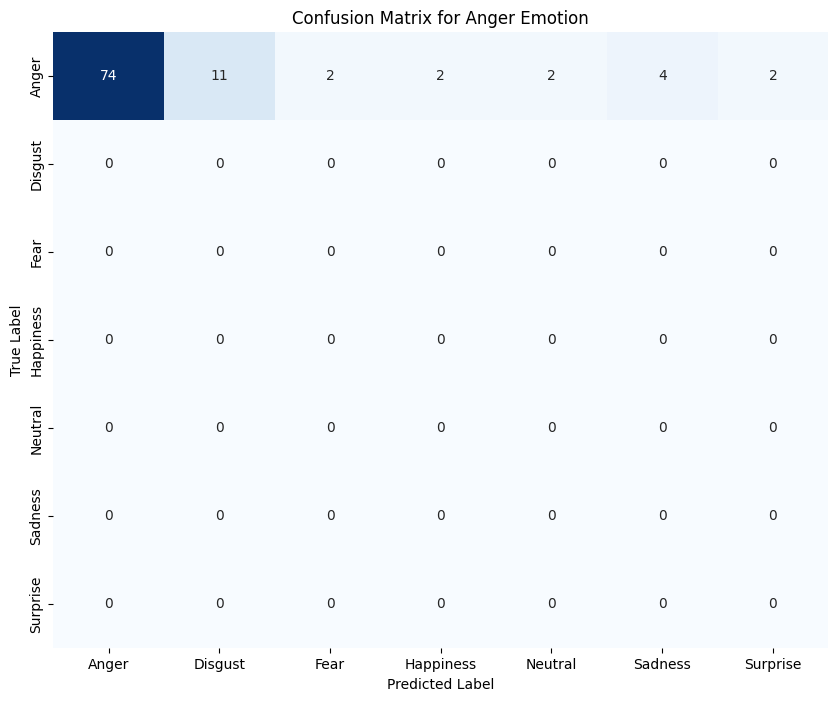

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have true_emotions_array and predicted_emotions_array

# Create the confusion matrix
cm_anger = confusion_matrix(true_emotions_array, predicted_emotions_array, labels=emotion_categories)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm_anger, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=emotion_categories, yticklabels=emotion_categories)
plt.title("Confusion Matrix for Anger Emotion")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import os

# Define the path to the Disgust folder
disgust_folder_path = '/content/drive/My Drive/Facial_Emotion_Recognition_Project/FER_25/Test/Disgust'

# Get a list of all image files in the Disgust folder
image_files = [f for f in os.listdir(disgust_folder_path) if os.path.isfile(os.path.join(disgust_folder_path, f))]

# Define your emotion categories
emotion_categories = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']

# Initialize empty lists to store predicted and true emotions
predicted_emotions_list = []
true_emotions_list = []

# Loop through each image file and make a prediction
for image_file in image_files:
    # Construct the full path to the image
    img_path = os.path.join(disgust_folder_path, image_file)  # Use disgust_folder_path

    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Make the prediction
    prediction = model.predict(img_array)

    # Get the predicted class index and emotion label
    predicted_class_index = np.argmax(prediction)
    predicted_emotion = emotion_categories[predicted_class_index]

    # Append the predicted emotion to the list
    predicted_emotions_list.append(predicted_emotion)

    # Append the true emotion (Disgust) to the list
    true_emotions_list.append('Disgust')  # Change to 'Disgust'

# Convert the lists to NumPy arrays
predicted_emotions_array = np.array(predicted_emotions_list)
true_emotions_array = np.array(true_emotions_list)

# Print the arrays of predicted and true emotions
print("Array of predicted emotions:")
print(predicted_emotions_array)
print("\nArray of true emotions:")
print(true_emotions_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

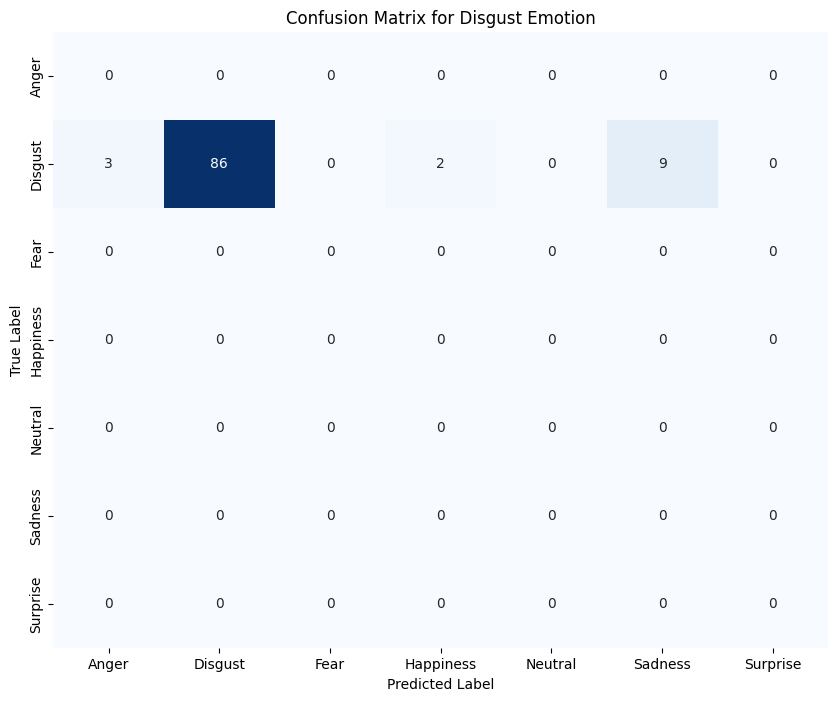

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have true_emotions_array and predicted_emotions_array from the previous cell

# Create the confusion matrix
cm_disgust = confusion_matrix(true_emotions_array, predicted_emotions_array, labels=emotion_categories)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm_disgust, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=emotion_categories, yticklabels=emotion_categories)
plt.title("Confusion Matrix for Disgust Emotion")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Combined Confusion Matrix:
[[74 11  2  2  2  4  2]
 [ 3 86  0  2  0  9  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]]


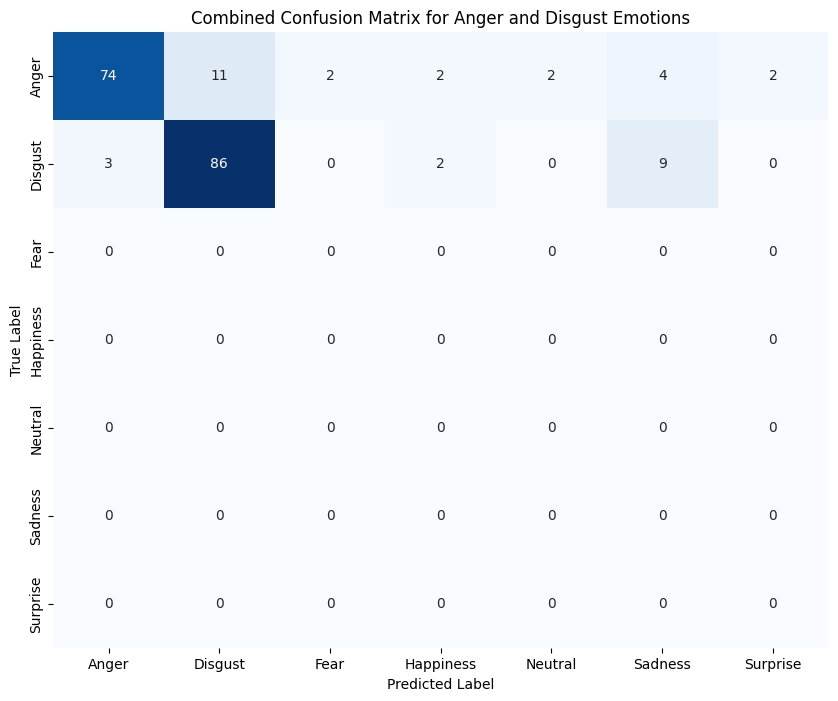

In [ ]:
import numpy as np

# Assuming you have cm_anger and cm_disgust from previous cells

# Add the two confusion matrices element-wise
combined_cm = cm_anger + cm_disgust

# Print the combined confusion matrix
print("Combined Confusion Matrix:")
print(combined_cm)

# You can also plot the combined confusion matrix using seaborn as before:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(combined_cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=emotion_categories, yticklabels=emotion_categories)
plt.title("Combined Confusion Matrix for Anger and Disgust Emotions")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━

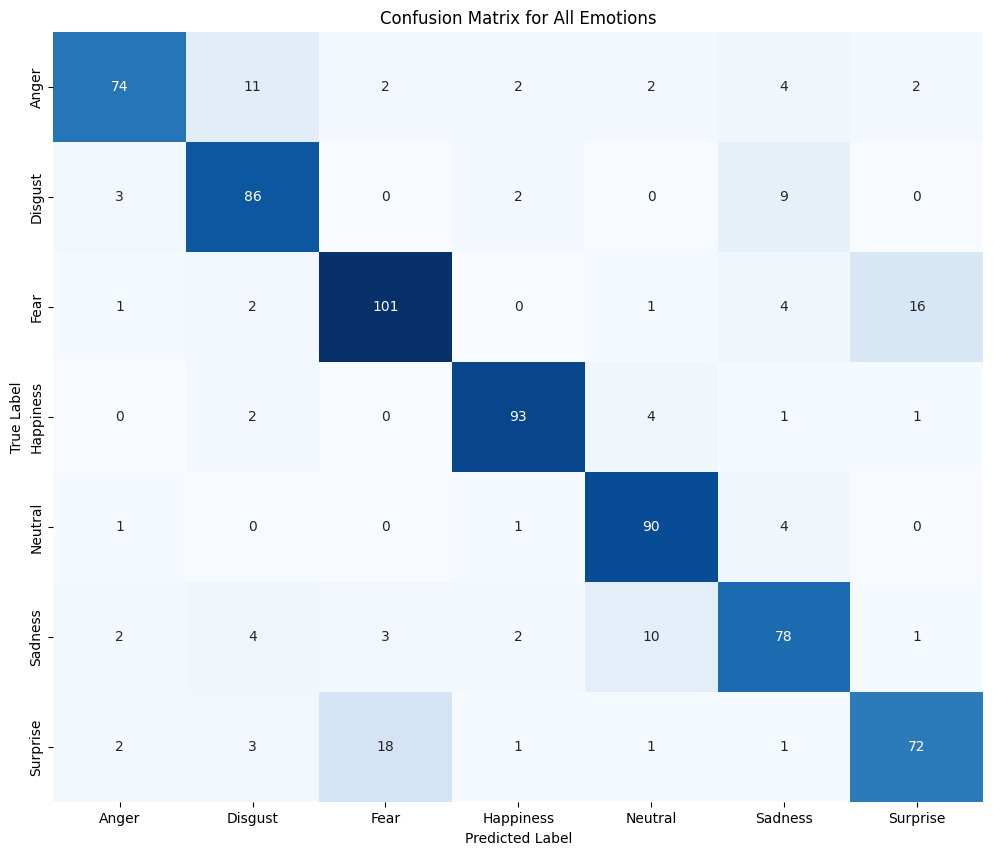

In [ ]:
import numpy as np
import os
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define your emotion categories
emotion_categories = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']

# Initialize empty lists to store all predicted and true emotions
all_predicted_emotions = []
all_true_emotions = []

# Loop through each emotion category
for emotion in emotion_categories:
    # Define the path to the emotion folder
    emotion_folder_path = os.path.join('/content/drive/My Drive/Facial_Emotion_Recognition_Project/FER_25/Test', emotion)

    # Get a list of all image files in the emotion folder
    image_files = [f for f in os.listdir(emotion_folder_path) if os.path.isfile(os.path.join(emotion_folder_path, f))]

    # Loop through each image file and make a prediction
    for image_file in image_files:
        # Construct the full path to the image
        img_path = os.path.join(emotion_folder_path, image_file)

        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        # Make the prediction
        prediction = model.predict(img_array)

        # Get the predicted class index and emotion label
        predicted_class_index = np.argmax(prediction)
        predicted_emotion = emotion_categories[predicted_class_index]

        # Append the predicted and true emotions to the lists
        all_predicted_emotions.append(predicted_emotion)
        all_true_emotions.append(emotion)  # True emotion is the current emotion category

# Convert the lists to NumPy arrays
all_predicted_emotions = np.array(all_predicted_emotions)
all_true_emotions = np.array(all_true_emotions)

# Create the confusion matrix
cm_all_emotions = confusion_matrix(all_true_emotions, all_predicted_emotions, labels=emotion_categories)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(cm_all_emotions, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=emotion_categories, yticklabels=emotion_categories)
plt.title("Confusion Matrix for All Emotions")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()